In [1]:
# === Cell 1: imports & config ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

try:
    import py21cmfast as p21
except Exception as e:
    raise RuntimeError("py21cmfast is required for these plots.") from e

# --- physical constants (cgs), consistent with secondrun.py ---
sigma_T = const.sigma_T.cgs.value       # [cm^2]
MPC_CM  = 3.0856775814913673e24         # [cm]

# --- box and redshift grid ---
HII_DIM = 64     # pixels per side
BOX_LEN = 200.0  # Mpc (comoving)
ZS       = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 09.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0]  # tweak freely (strictly decreasing helps some routines)

voxel = BOX_LEN / HII_DIM
BOX_LABEL = f"Box: {BOX_LEN:.0f} Mpc, {HII_DIM}^3 (Δx={voxel:.2f} Mpc)"
print(BOX_LABEL, "\nzs =", ZS)


Box: 200 Mpc, 64^3 (Δx=3.12 Mpc) 
zs = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0]


Explanation of Cell 2: Helpers (from secondrun.py style)
This cell defines several helper functions and constants that are used throughout the notebook. Here's a breakdown of its components:

ne0_cgs Function:

Computes the mean electron density today (n_e0) in units of cm^-3.
Accounts for singly-ionized helium if include_He=True.
Uses constants from astropy for proton mass, critical density, and baryon density fraction.
run_coeval_fields Function:

Runs a 21cmFAST coeval box simulation for a given redshift z.
Returns key fields:
delta: Matter overdensity (dimensionless).
chi: Ionized fraction (1 - neutral fraction).
vx, vy, vz: Velocity components in cm/s.
build_momentum Function:

Computes the specific ionized momentum q = (1 + δ) χ v for each velocity component (qx, qy, qz).
central_slice Function:

Extracts a central slice (midpoint along the x-axis) from a 3D array.
Useful for visualizing 2D slices of 3D data.
title_with_box Function:

Generates a formatted title string for plots, including the redshift z and box dimensions.
Key Constants:
sigma_T: Thomson scattering cross-section in cm^2.
MPC_CM: Conversion factor from megaparsecs to centimeters.
HII_DIM: Number of pixels per side of the simulation box.
BOX_LEN: Length of the simulation box in megaparsecs.
These helpers streamline the workflow by encapsulating common calculations and operations, making the code modular and reusable.

In [2]:
# === Cell 2: helpers (from secondrun.py style) ===

def ne0_cgs(Y_He=0.24, include_He=True):
    """Mean electron density today [cm^-3], including singly-ionized He if include_He."""
    m_p    = const.m_p.cgs.value
    rho_c0 = cosmo.critical_density0.cgs.value
    Om_b   = cosmo.Ob0
    n_b0   = (Om_b * rho_c0) / m_p
    X_H    = 1.0 - Y_He
    n_H0   = X_H * n_b0
    if include_He:
        y = Y_He / (4.0 * X_H)  # He/H by number
        electrons_per_H = 1.0 + y  # H (1) + singly ionized He (1)
    else:
        electrons_per_H = 1.0
    return n_H0 * electrons_per_H

ne0 = ne0_cgs()
print("n_e0 [cm^-3] =", ne0)

def run_coeval_fields(z, HII_DIM=HII_DIM, BOX_LEN=BOX_LEN):
    """Run a 21cmFAST coeval box and return needed fields."""
    coeval = p21.run_coeval(
        redshift=float(z),
        user_params={"HII_DIM": int(HII_DIM), "BOX_LEN": float(BOX_LEN)},
        write=False,
    )
    delta  = coeval.density               # matter overdensity δ (dimensionless)
    xH     = coeval.xH_box                # neutral fraction
    chi    = 1.0 - xH                     # ionized fraction χ
    vx     = coeval.lowres_vx * 1e5       # km/s -> cm/s
    vy     = coeval.lowres_vy * 1e5
    vz     = coeval.lowres_vz * 1e5
    return delta, chi, vx, vy, vz

def build_momentum(delta, chi, vx, vy, vz):
    """Specific ionized momentum q = (1+δ) χ v (no FFTs)."""
    ne_fluct = (1.0 + delta) * chi
    qx = ne_fluct * vx
    qy = ne_fluct * vy
    qz = ne_fluct * vz
    return qx, qy, qz

def central_slice(arr):
    """Take central x-slice (ix=N//2) -> [N, N] panel."""
    N = arr.shape[0]
    return arr[N//2, :, :]

def title_with_box(base, z):
    return f"{base} (z={z})\n{BOX_LABEL}"


n_e0 [cm^-3] = 2.0643566911920377e-07


Explanation of Cell 3: Building Slices for δ, v_x, v_y, v_z, q_x, q_y, q_z, and x_e at Each Redshift
This cell processes the simulation data for a specific redshift to extract and visualize key physical quantities. Here's a breakdown of the steps:

Redshift Selection:

The redshift(s) of interest are defined in the list ZS1. For each redshift, the corresponding simulation data is processed.
Field Extraction:

The run_coeval_fields function is used to generate the following fields:
delta: Matter overdensity (dimensionless).
chi: Ionized fraction (1 - neutral fraction).
vx, vy, vz: Velocity components in cm/s.
The build_momentum function computes the specific ionized momentum components (qx, qy, qz).
Central Slices:

The central_slice function extracts 2D slices from the center of the 3D simulation box for each field:
δ_sl: Slice of matter overdensity.
xe_sl: Slice of ionized fraction.
vx_sl, vy_sl, vz_sl: Slices of velocity components.
qx_sl, qy_sl, qz_sl: Slices of momentum components.
Visualization:

A 2x4 grid of subplots is created to visualize the slices:
Row 1: δ, v_x, v_y, v_z.
Row 2: x_e, q_x, q_y, q_z.
Each subplot includes a colorbar and appropriate labels.
Saving and Summary:

The figure is saved as an image file (slice_z_5).
A summary line is printed for each redshift, showing:
The mean ionized fraction (<x_e>).
The minimum and maximum values of the matter overdensity (δ).
This cell provides a detailed visualization of the physical quantities at a given redshift, aiding in the analysis of the simulation data.

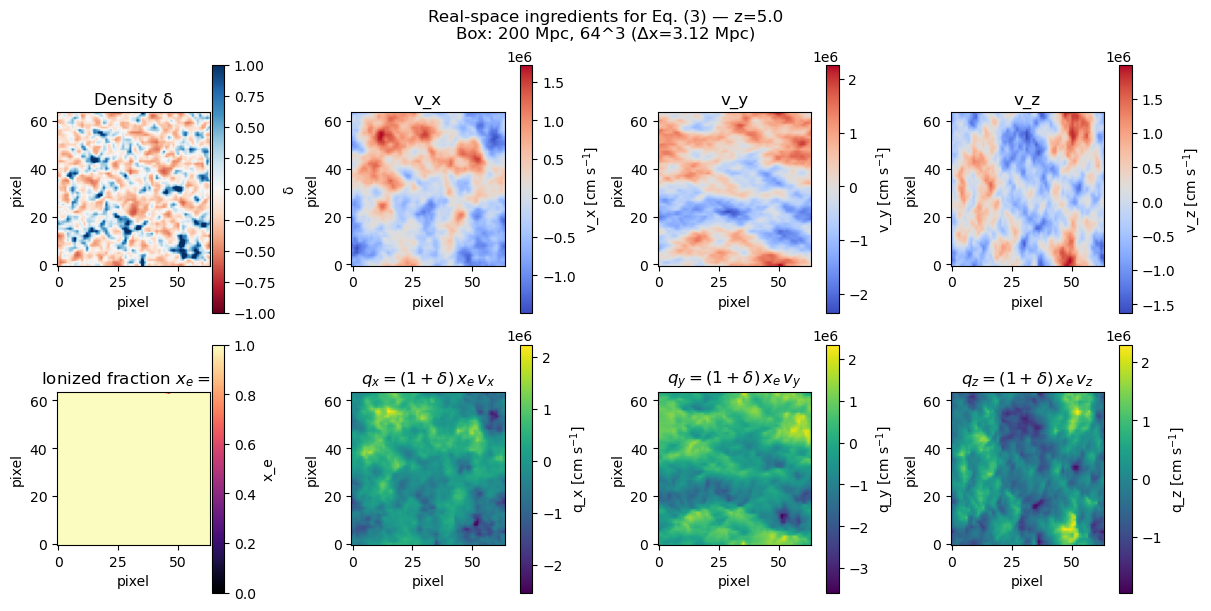

z=5.0:  <x_e> = 0.999 | δ min/max = -0.72/4.32


In [37]:
# === Cell 3: build slices for δ, v_x, v_y, v_z, q_x, q_y, q_z, and x_e at each redshift ===
ZS1=[5.0]
for z in ZS1:
    # fields (from your Cell 2 helpers)
    delta, chi, vx, vy, vz = run_coeval_fields(z)
    qx, qy, qz = build_momentum(delta, chi, vx, vy, vz)

    # central slices
    δ_sl   = central_slice(delta)
    xe_sl  = central_slice(chi)
    vx_sl  = central_slice(vx)
    vy_sl  = central_slice(vy)
    vz_sl  = central_slice(vz)
    qx_sl  = central_slice(qx)
    qy_sl  = central_slice(qy)
    qz_sl  = central_slice(qz)

    # figure: 2 rows x 4 cols
    fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
    fig.suptitle(f"Real-space ingredients for Eq. (3) — z={z}\n{BOX_LABEL}", fontsize=12)

    # Row 1: δ, v_x, v_y, v_z
    im = axs[0,0].imshow(δ_sl, origin="lower", cmap="RdBu", vmin=-1, vmax=1)
    plt.colorbar(im, ax=axs[0,0], pad=0.01, label="δ")
    axs[0,0].set_title("Density δ"); axs[0,0].set_xlabel("pixel"); axs[0,0].set_ylabel("pixel")

    im = axs[0,1].imshow(vx_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,1], pad=0.01, label="v_x [cm s$^{-1}$]")
    axs[0,1].set_title("v_x"); axs[0,1].set_xlabel("pixel"); axs[0,1].set_ylabel("pixel")

    im = axs[0,2].imshow(vy_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,2], pad=0.01, label="v_y [cm s$^{-1}$]")
    axs[0,2].set_title("v_y"); axs[0,2].set_xlabel("pixel"); axs[0,2].set_ylabel("pixel")

    im = axs[0,3].imshow(vz_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,3], pad=0.01, label="v_z [cm s$^{-1}$]")
    axs[0,3].set_title("v_z"); axs[0,3].set_xlabel("pixel"); axs[0,3].set_ylabel("pixel")

    # Row 2: x_e, q_x, q_y, q_z
    im = axs[1,0].imshow(xe_sl, origin="lower", cmap="magma", vmin=0, vmax=1)
    plt.colorbar(im, ax=axs[1,0], pad=0.01, label="x_e")
    axs[1,0].set_title(r"Ionized fraction $x_e=\chi$"); axs[1,0].set_xlabel("pixel"); axs[1,0].set_ylabel("pixel")

    im = axs[1,1].imshow(qx_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,1], pad=0.01, label="q_x [cm s$^{-1}$]")
    axs[1,1].set_title(r"$q_x=(1+\delta)\,x_e\,v_x$"); axs[1,1].set_xlabel("pixel"); axs[1,1].set_ylabel("pixel")

    im = axs[1,2].imshow(qy_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,2], pad=0.01, label="q_y [cm s$^{-1}$]")
    axs[1,2].set_title(r"$q_y=(1+\delta)\,x_e\,v_y$"); axs[1,2].set_xlabel("pixel"); axs[1,2].set_ylabel("pixel")

    im = axs[1,3].imshow(qz_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,3], pad=0.01, label="q_z [cm s$^{-1}$]")
    axs[1,3].set_title(r"$q_z=(1+\delta)\,x_e\,v_z$"); axs[1,3].set_xlabel("pixel"); axs[1,3].set_ylabel("pixel")

    plt.savefig("slice_z_5")
    plt.show()

    # quick summary line per z
    print(f"z={z}:  <x_e> = {chi.mean():.3f} | δ min/max = {delta.min():.2f}/{delta.max():.2f}")


Same as above cell but now saves all the redshift images to an output folder

In [3]:
# === Cell 3 (with saving): δ, v_i, q_i, x_e slices ===
import os

outdir = "slices_outputs"
os.makedirs(outdir, exist_ok=True)

for z in ZS:
    # fields
    delta, chi, vx, vy, vz = run_coeval_fields(z)
    qx, qy, qz = build_momentum(delta, chi, vx, vy, vz)

    # central slices
    δ_sl   = central_slice(delta)
    xe_sl  = central_slice(chi)
    vx_sl  = central_slice(vx)
    vy_sl  = central_slice(vy)
    vz_sl  = central_slice(vz)
    qx_sl  = central_slice(qx)
    qy_sl  = central_slice(qy)
    qz_sl  = central_slice(qz)

    # figure
    fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
    fig.suptitle(f"Real-space ingredients for Eq. (3) — z={z}\n{BOX_LABEL}", fontsize=12)

    # Row 1
    im = axs[0,0].imshow(δ_sl, origin="lower", cmap="RdBu", vmin=-1, vmax=1)
    plt.colorbar(im, ax=axs[0,0], pad=0.01, label="δ")
    axs[0,0].set_title("Density δ")

    im = axs[0,1].imshow(vx_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,1], pad=0.01, label="v_x [cm s$^{-1}$]")
    axs[0,1].set_title("v_x")

    im = axs[0,2].imshow(vy_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,2], pad=0.01, label="v_y [cm s$^{-1}$]")
    axs[0,2].set_title("v_y")

    im = axs[0,3].imshow(vz_sl, origin="lower", cmap="coolwarm")
    plt.colorbar(im, ax=axs[0,3], pad=0.01, label="v_z [cm s$^{-1}$]")
    axs[0,3].set_title("v_z")

    # Row 2
    im = axs[1,0].imshow(xe_sl, origin="lower", cmap="magma", vmin=0, vmax=1)
    plt.colorbar(im, ax=axs[1,0], pad=0.01, label="x_e")
    axs[1,0].set_title(r"Ionized fraction $x_e$")

    im = axs[1,1].imshow(qx_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,1], pad=0.01, label="q_x [cm s$^{-1}$]")
    axs[1,1].set_title(r"$q_x$")

    im = axs[1,2].imshow(qy_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,2], pad=0.01, label="q_y [cm s$^{-1}$]")
    axs[1,2].set_title(r"$q_y$")

    im = axs[1,3].imshow(qz_sl, origin="lower", cmap="viridis")
    plt.colorbar(im, ax=axs[1,3], pad=0.01, label="q_z [cm s$^{-1}$]")
    axs[1,3].set_title(r"$q_z$")

    # save instead of just show
    outfile = os.path.join(outdir, f"fields_z{z:.1f}.png")
    plt.savefig(outfile, dpi=150)
    plt.close(fig)  # close to free memory

    print(f"Saved {outfile} | <x_e>={chi.mean():.3f}")


/home/swanith/miniconda3/envs/21cmfast-env/lib/python3.10/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


Saved slices_outputs/fields_z16.0.png | <x_e>=0.003
Saved slices_outputs/fields_z15.5.png | <x_e>=0.004
Saved slices_outputs/fields_z15.0.png | <x_e>=0.006
Saved slices_outputs/fields_z14.5.png | <x_e>=0.009
Saved slices_outputs/fields_z14.0.png | <x_e>=0.013
Saved slices_outputs/fields_z13.5.png | <x_e>=0.018
Saved slices_outputs/fields_z13.0.png | <x_e>=0.025
Saved slices_outputs/fields_z12.5.png | <x_e>=0.035
Saved slices_outputs/fields_z12.0.png | <x_e>=0.049
Saved slices_outputs/fields_z11.5.png | <x_e>=0.065
Saved slices_outputs/fields_z11.0.png | <x_e>=0.087
Saved slices_outputs/fields_z10.5.png | <x_e>=0.116
Saved slices_outputs/fields_z10.0.png | <x_e>=0.155
Saved slices_outputs/fields_z9.5.png | <x_e>=0.201
Saved slices_outputs/fields_z9.0.png | <x_e>=0.262
Saved slices_outputs/fields_z8.5.png | <x_e>=0.344
Saved slices_outputs/fields_z8.0.png | <x_e>=0.438
Saved slices_outputs/fields_z7.5.png | <x_e>=0.566
Saved slices_outputs/fields_z7.0.png | <x_e>=0.735
Saved slices_outpu

In [3]:
# === Cell 3: choose a "showcase" redshift for detailed slices ===
#z_show = 8.0  # change if you like
delta, chi, vx, vy, vz = run_coeval_fields(z_show)
qx, qy, qz = build_momentum(delta, chi, vx, vy, vz)

# Perpendicular velocity relative to the LOS (take LOS = ẑ): v_perp = sqrt(vx^2 + vy^2)
vperp = np.sqrt(vx**2 + vy**2)

# Perpendicular momentum magnitude: q_perp = sqrt(qx^2 + qy^2)
qperp = np.sqrt(qx**2 + qy**2)

# Momentum magnitude
qmag = np.sqrt(qx**2 + qy**2 + qz**2)

# Prepare central slices
δ_sl     = central_slice(delta)
vz_sl    = central_slice(vz)
vperp_sl = central_slice(vperp)
qmag_sl  = central_slice(qmag)
qz_sl    = central_slice(qz)
qperp_sl = central_slice(qperp)

print("slice shapes:", δ_sl.shape)


/home/swanith/miniconda3/envs/21cmfast-env/lib/python3.10/site-packages/py21cmfast/inputs.py:515: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


slice shapes: (64, 64)


Calculation of TAu and VIsibility

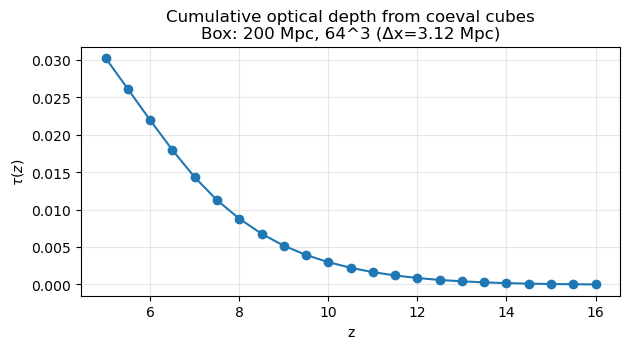

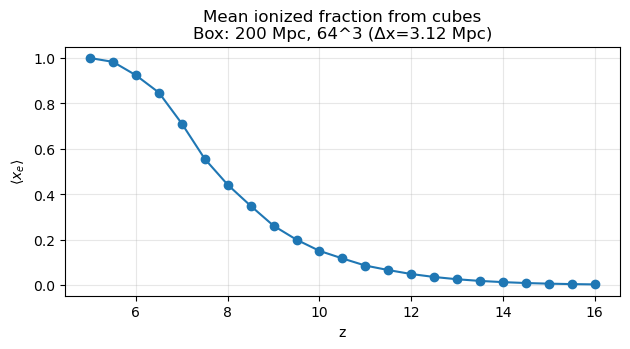

In [ ]:
# === Cell 10: tau(z) and visibility from coeval cubes ===
# build z -> <x_e> from the same runs we used above
zs_arr = np.array(ZS, dtype=float)
chi_means = []
for z in zs_arr:
    _, chi, *_ = run_coeval_fields(z)
    chi_means.append( float(chi.mean()) )
chi_means = np.array(chi_means)

# geometry
chis = np.array([cosmo.comoving_distance(z).value for z in zs_arr])  # [Mpc], increasing with z
# ensure we integrate from high z -> low z
order = np.argsort(zs_arr)[::-1]
zs_sorted   = zs_arr[order]
chis_sorted = chis[order]
xe_sorted   = chi_means[order]

# comoving bin widths (positive)
dchi = np.empty_like(chis_sorted)
dchi[:-1] = np.diff(chis_sorted)
dchi[-1]  = dchi[-2] if len(dchi) > 1 else 0.0
dchi = np.abs(dchi)  # [Mpc]

# accumulate tau from high->low z (τ=0 at highest z by convention)
tau = np.zeros_like(zs_sorted, dtype=float)
running = 0.0
for i in range(len(zs_sorted)-1):
    zmid  = 0.5*(zs_sorted[i] + zs_sorted[i+1])
    a_mid = 1.0/(1.0 + zmid)
    xe_mid = 0.5*(xe_sorted[i] + xe_sorted[i+1])
    dtaus = sigma_T * ne0 * xe_mid * (a_mid**-2) * (dchi[i] * MPC_CM)
    running += dtaus
    tau[i+1] = running

# restore original z order for plotting
unsort = np.argsort(order)
tau_plot = tau[unsort]
zs_plot  = zs_sorted[unsort]

plt.figure(figsize=(6.4,3.6))
plt.plot(zs_plot, tau_plot, marker='o')
plt.xlabel("z"); plt.ylabel(r"$\tau(z)$")
plt.title(f"Cumulative optical depth from coeval cubes\n{BOX_LABEL}")
#plt.grid(alpha=0.3); plt.tight_layout();plt.savefig("tau_box") ;plt.show()

#plt.figure(figsize=(6.4,3.6))
#plt.plot(zs_plot, np.exp(-2.0*tau_plot), marker='o')
#plt.xlabel("z"); plt.ylabel(r"$\exp(-2\tau)$")
#plt.title(f"Visibility factor vs redshift\n{BOX_LABEL}")
#plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.4,3.6))
plt.plot(zs_plot, xe_sorted[unsort], marker='o')
plt.xlabel("z"); plt.ylabel(r"$\langle x_e\rangle$")
plt.title(f"Mean ionized fraction from cubes\n{BOX_LABEL}")
#plt.grid(alpha=0.3); plt.tight_layout();plt.savefig("x_e_box") ;plt.show()


In [12]:
# === Cell 4: q_perp in k-space + power spectrum estimator (as in secondrun.py) ===
import numpy as np

def qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None):
    """
    Build q=(1+δ)χv, FFT to Q(k), project to Q_perp, estimate P_{q_perp}(k).
    Returns:
      k_bin (Mpc^-1), P_bin (cm^2 s^-2 Mpc^3), 
      qperp_slice (real-space |q_perp| mid-slice), 
      kplane_amp (|Q| mid-kz plane, fftshifted), 
      kplane_amp_perp (|Q_perp| mid-kz plane, fftshifted), 
      kx2d, ky2d (fftshifted, for plotting axes)
    """
    # --- real-space q ---
    ne_fluct = (1.0 + delta) * chi
    qx = ne_fluct * vx
    qy = ne_fluct * vy
    qz = ne_fluct * vz

    # --- geometry ---
    N = qx.shape[0]
    L = float(BOX_LEN)          # Mpc (comoving)
    d = L / N                   # Mpc
    V = L**3                    # Mpc^3

    # --- k-grid (1/Mpc) ---
    kfreq = np.fft.fftfreq(N, d=d) * 2.0*np.pi  # fundamental spacing 2π/L
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing="ij")
    k2 = kx*kx + ky*ky + kz*kz
    k = np.sqrt(k2)
    k2_safe = np.where(k2 == 0.0, np.inf, k2)   # avoid div0 at k=0

    # --- FFT with continuous-FT normalization (× voxel volume) ---
    Qx = np.fft.fftn(qx) * (d**3)
    Qy = np.fft.fftn(qy) * (d**3)
    Qz = np.fft.fftn(qz) * (d**3)

    # --- project to transverse: Q_perp = Q - khat (Q·khat) ---
    kdotQ_over_k2 = (Qx*kx + Qy*ky + Qz*kz) / k2_safe
    Qx_perp = Qx - kdotQ_over_k2 * kx
    Qy_perp = Qy - kdotQ_over_k2 * ky
    Qz_perp = Qz - kdotQ_over_k2 * kz

    # --- power estimator: P(k) = <|Q_perp|^2>/V ---
    Qperp2 = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)
    p_flat = (Qperp2 / V).ravel()
    k_flat = k.ravel()

    # --- radial binning in k ---
    if nbins is None:
        nbins = int(np.ceil(np.cbrt(N) * 8))  # same heuristic spirit as secondrun.py
    kmin = np.abs(kfreq[1]) if N > 1 else 1e-6
    kmax = kfreq.max() * np.sqrt(3.0)
    bins = np.geomspace(kmin, kmax, nbins)
    digit = np.digitize(k_flat, bins)

    kvals, pvals, counts = [], [], []
    for i in range(1, len(bins)):
        mask = digit == i
        if not np.any(mask):
            continue
        kvals.append(k_flat[mask].mean())
        pvals.append(p_flat[mask].mean())
        counts.append(mask.sum())

    # --- optional visuals: real-space |q_perp| mid-slice, and k-plane amplitudes (fftshifted) ---
    # real-space q_perp via iFFT (invert our normalization)
    qx_perp_r = np.fft.ifftn(Qx_perp) / (d**3)
    qy_perp_r = np.fft.ifftn(Qy_perp) / (d**3)
    qz_perp_r = np.fft.ifftn(Qz_perp) / (d**3)
    qperp_mag = np.sqrt(np.abs(qx_perp_r)**2 + np.abs(qy_perp_r)**2 + np.abs(qz_perp_r)**2).real

    mid = N//2
    qperp_slice = qperp_mag[mid, :, :]

    # mid-kz plane, amplitude and fftshift for centered display
    plane_Q      = (np.abs(Qx)**2 + np.abs(Qy)**2 + np.abs(Qz)**2)**0.5
    plane_Qperp  = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)**0.5
    kplane_amp       = np.fft.fftshift(plane_Q[:, :, mid])
    kplane_amp_perp  = np.fft.fftshift(plane_Qperp[:, :, mid])

    kx2 = np.fft.fftshift(kx[:, :, mid])
    ky2 = np.fft.fftshift(ky[:, :, mid])

    return (np.array(kvals), np.array(pvals),
            qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2)


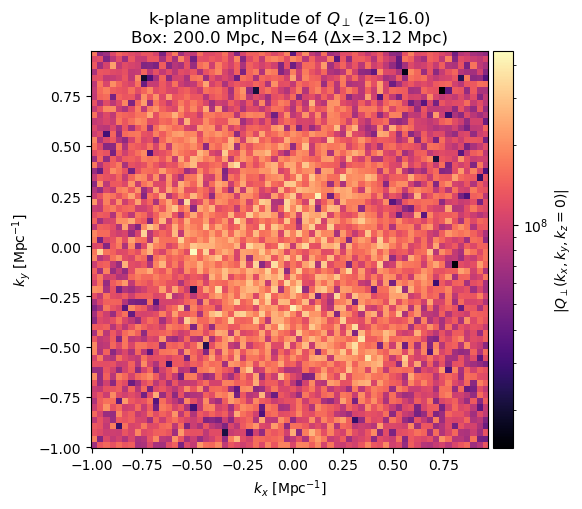

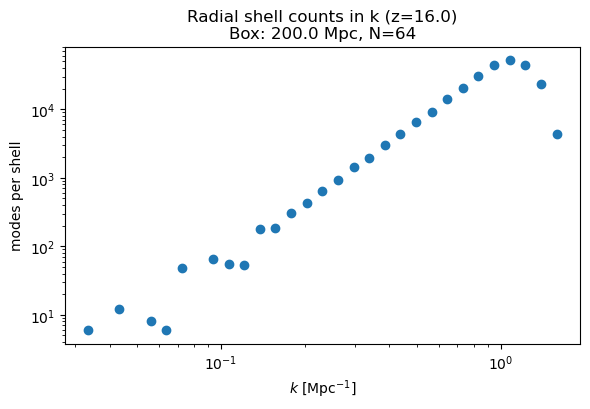

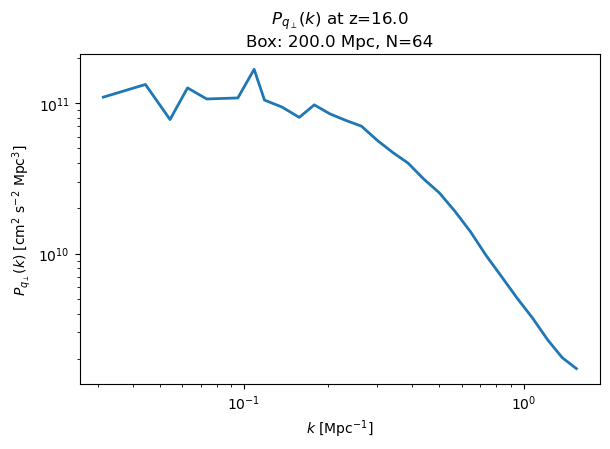

In [56]:
# === Cell 5b: Fourier-space diagnostics with box scales ===
from matplotlib.colors import LogNorm
z_show = 16.0  # change if you like

# recompute geometry
N = delta.shape[0]
L = BOX_LEN
d = L / N
#kfund = 2*np.pi / L       # fundamental mode
#knyq  = np.pi / d         # Nyquist mode

# (B) k-space mid-kz plane (|Q_perp|)
plt.figure(figsize=(6.2,5.2))
im = plt.imshow(kplane_amp_perp, origin="lower", cmap="magma", norm=LogNorm(),
                extent=[kx2.min(), kx2.max(), ky2.min(), ky2.max()], aspect="equal")
plt.colorbar(im, pad=0.01, label=r"$|Q_\perp(k_x,k_y,k_z{=}0)|$")
plt.xlabel(r"$k_x$ [Mpc$^{-1}$]")
plt.ylabel(r"$k_y$ [Mpc$^{-1}$]")
plt.title(
    f"k-plane amplitude of $Q_\\perp$ (z={z_show})\n"
    f"Box: {L} Mpc, N={N} (Δx={d:.2f} Mpc)"
)
plt.tight_layout(); plt.savefig("q_perp_mid_kz_slice"); plt.show()

# (C) radial shell counts in k
plt.figure(figsize=(6.0,4.2))
plt.loglog(centers, counts, marker="o", ls="none")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")
plt.ylabel("modes per shell")
plt.title(
    f"Radial shell counts in k (z={z_show})\n"
    f"Box: {L} Mpc, N={N}"
)
plt.tight_layout(); plt.savefig("number_of_modes_in_bins"); plt.show()

# (D) binned power spectrum
plt.figure(figsize=(6.2,4.6))
plt.loglog(kbins, Pbins, lw=2)
plt.xlabel(r"$k$ [Mpc$^{-1}$]")
plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
plt.title(
    f"$P_{{q_\\perp}}(k)$ at z={z_show}\n"
    f"Box: {L} Mpc, N={N}"
)
plt.tight_layout(); plt.savefig("P_q_perp_vs_z"); plt.show()


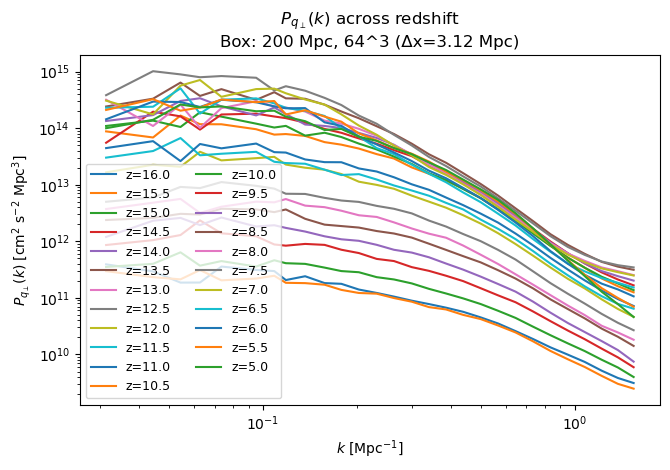

In [13]:
# === Cell 6: P_{q_perp}(k,z) curves across your redshift list (like secondrun.py) ===
all_curves = []

for z in ZS:
    delta, chi, vx, vy, vz = run_coeval_fields(z)
    kbins, Pbins, *_ = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None)
    all_curves.append((z, kbins, Pbins))

# Plot
plt.figure(figsize=(6.8,4.8))
for z, k_i, P_i in all_curves:
    plt.loglog(k_i, P_i, label=f"z={z}")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")
plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
plt.title(r"$P_{q_\perp}(k)$ across redshift" + f"\n{BOX_LABEL}")
#plt.grid(True, which="both", alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.savefig("p_q_per_for_all_z"); plt.show()


D_3000 [μK^2] ≈ 2.9581090991703772e-27


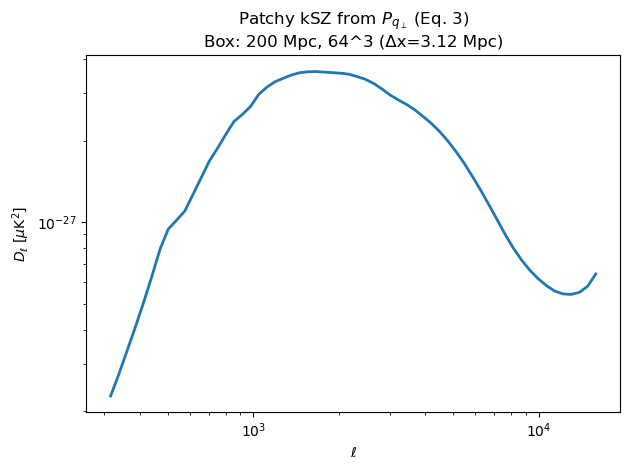

In [14]:
# --- Minimal Eq.(3) line-of-sight integral (NO new coevals) ---

import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

# Expect in memory:
#   all_curves : list of (z, kbins, Pbins)
#   ZS         : iterable of z used to make all_curves
# Optional (preferred to keep 1:1 with your earlier plots):
#   chis, a_z, dchi  : geometry arrays aligned with ZS (high->low or low->high is fine)
#   vis2 or tau_by_z or vis2_by_z : e^{-2 tau(z)} weights aligned with ZS
#
# Nothing here calls run_coeval_fields or rebuilds P_{q_perp}.

# Constants (same as your notebook/secondrun.py)
sigma_T = const.sigma_T.cgs.value
c_cms   = const.c.cgs.value
MPC_CM  = 3.0856775814913673e24
T_CMB_K = 2.7255
K_to_uK = 1e6

def ne0_cgs(Y_He=0.24, include_He=True):
    m_p    = const.m_p.cgs.value
    rho_c0 = cosmo.critical_density0.cgs.value
    Om_b   = cosmo.Ob0
    n_b0   = (Om_b * rho_c0) / m_p
    X_H    = 1.0 - Y_He
    n_H0   = X_H * n_b0
    if include_He:
        y = Y_He / (4.0 * X_H)
        electrons_per_H = 1.0 + y  # H + singly-ionized He
    else:
        electrons_per_H = 1.0
    return n_H0 * electrons_per_H

ne0 = ne0_cgs()

# Pull arrays from your existing curves (NO recompute)
z_arr, k_list, P_list = [], [], []
for z, kb, Pb in all_curves:
    z_arr.append(float(z)); k_list.append(np.asarray(kb)); P_list.append(np.asarray(Pb))
z_arr = np.asarray(z_arr)

# Sort high->low z for LOS accumulation
order = np.argsort(-z_arr)
z_arr  = z_arr[order]
k_list = [k_list[i] for i in order]
P_list = [P_list[i] for i in order]

# Geometry: use your existing geometry if present; otherwise compute distances only (still no coevals)
def get_geometry(z_sorted):
    if 'chis' in globals() and 'a_z' in globals() and 'dchi' in globals():
        # Map your existing arrays by redshift value
        ZS_arr = np.asarray(list(ZS), dtype=float)
        map_chi = {float(ZS_arr[i]): float(chis[i]) for i in range(len(ZS_arr))}
        map_a   = {float(ZS_arr[i]): float(a_z[i])  for i in range(len(ZS_arr))}
        # dchi is between successive z's; rebuild in sorted order from your provided dchi if available
        chi_sorted = np.array([map_chi[float(z)] for z in z_sorted])
        a_sorted   = np.array([map_a[float(z)] for z in z_sorted])
        # If you also had dchi per original order, just recompute widths from chi (no physics reruns)
        dchi_sorted = np.empty_like(chi_sorted)
        dchi_sorted[:-1] = np.diff(chi_sorted)
        dchi_sorted[-1]  = dchi_sorted[-2] if len(dchi_sorted) > 1 else 0.0
        return chi_sorted, a_sorted, np.abs(dchi_sorted)
    else:
        # Safe fallback: distances and scale factor from cosmology only
        chi_sorted = np.array([cosmo.comoving_distance(z).value for z in z_sorted])  # [Mpc]
        a_sorted   = 1.0/(1.0 + z_sorted)
        dchi_sorted = np.empty_like(chi_sorted)
        dchi_sorted[:-1] = np.diff(chi_sorted)
        dchi_sorted[-1]  = dchi_sorted[-2] if len(dchi_sorted) > 1 else 0.0
        return chi_sorted, a_sorted, np.abs(dchi_sorted)

chis_sorted, a_sorted, dchi_sorted = get_geometry(z_arr)
ds_cm = dchi_sorted * MPC_CM

# Visibility e^{-2 tau}: use what you already have; else neutral weight (=1)
def get_vis2(z_sorted):
    if 'vis2_by_z' in globals() and isinstance(vis2_by_z, dict):
        return np.array([float(vis2_by_z[float(z)]) for z in z_sorted], dtype=float)
    if 'tau_by_z' in globals() and isinstance(tau_by_z, dict):
        return np.exp(-2.0*np.array([float(tau_by_z[float(z)]) for z in z_sorted], dtype=float))
    if 'vis2' in globals():
        ZS_arr = np.asarray(list(ZS), dtype=float)
        mapping = {float(ZS_arr[i]): float(vis2[i]) for i in range(len(ZS_arr))}
        return np.array([mapping[float(z)] for z in z_sorted], dtype=float)
    return np.ones_like(z_sorted, dtype=float)

vis2_sorted = get_vis2(z_arr)

# Log–log P interpolation (no extrapolation beyond your k-range)
def interp_loglog(xq, xp, fp):
    xp = np.asarray(xp); fp = np.asarray(fp)
    m  = (xp > 0) & (fp > 0)
    lx = np.log(xp[m]); lf = np.log(fp[m])
    lq = np.log(np.clip(xq, xp[m].min(), xp[m].max()))
    return np.exp(np.interp(lq, lx, lf, left=lf[0], right=lf[-1]))

# ℓ grid (tweak as you like)
ells = np.unique(np.round(np.logspace(2.5, 4.2, 60))).astype(int)

# Eq.(3): C_ell = (σ_T n_e0 / c)^2 Σ_i [ e^{-2τ_i} / (s_i^2 a_i^4) * P_{q⊥}(ℓ/s_i, z_i) * ds_i ]
pref = (sigma_T * ne0 / c_cms)**2
C_ell = np.zeros_like(ells, dtype=float)

for i in range(len(z_arr)):
    s     = chis_sorted[i]
    a     = a_sorted[i]
    w     = vis2_sorted[i] / (s**2 * a**4) * ds_cm[i]
    k_now = ells / s
    P_now = interp_loglog(k_now, k_list[i], P_list[i])
    C_ell += pref * w * P_now

D_ell_uK2 = ells*(ells+1.0)/(2.0*np.pi) * C_ell * (T_CMB_K**2) * (K_to_uK**2)

# Output identical-style plot/number
D3000 = float(np.interp(3000.0, ells, D_ell_uK2))
print("D_3000 [μK^2] ≈", D3000)

plt.figure(figsize=(6.4,4.8))
plt.loglog(ells, D_ell_uK2, lw=2)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$ [$\mu$K$^2$]")
plt.title("Patchy kSZ from $P_{q_\\perp}$ (Eq. 3)" + (f"\n{BOX_LABEL}" if 'BOX_LABEL' in globals() else ""))
#plt.grid(True, which="both", alpha=0.25)
plt.tight_layout(); plt.savefig("pksz_from_pqperp_eq3"); plt.savefig("D_pksZ_l"); plt.show()
